# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import numpy as np
import os
#from scipy.ndimage import imread, imresize (depricated)
from skimage.io import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30) #old code need changes
#tf.random.set_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
!ls

Exp_2_Vinay_Vamsi_Neural_Nets_Project_Starter_Code-Backup.ipynb
Exp_3_Vinay_Vamsi_Neural_Nets_Project_Starter_Code.ipynb
Exp_Vinay_Vamsi_Neural_Nets_Project_Starter_Code-Copy1.ipynb
First_save_vinay_Neural_Nets_Project_Starter_Code-Copy1.ipynb
First_save_vinay_Neural_Nets_Project_Starter_Code.ipynb
Neural_Nets_Project_Starter_Code.ipynb
Project_data
Project_data.zip
Second_save_vinay_Neural_Nets_Project_Starter_Code.ipynb
Vinay_Neural_Nets_Project_Starter_Code-Copy1.ipynb
Vinay_Neural_Nets_Project_Starter_Code_conv3D.ipynb
Vinay_Vamsi_Neural_Nets_Project_Starter_Code-Backup.ipynb
Vinay_Vamsi_Neural_Nets_Project_Starter_Code.ipynb
Ziip_filed_download.ipynb
model_init_2020-12-2407_10_03.006800
model_init_2020-12-2412_25_32.113956
model_init_2020-12-2415_04_34.679294
model_init_2020-12-2415_36_49.853551
model_init_2020-12-2417_48_13.633473
model_init_2020-12-2517_25_13.811781


In [5]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size
# Tried with less epoch first very accuracy was less

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
image_x_shape = 84
image_y_shape = 84

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,4,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    x, y, z = len(img_idx), image_x_shape, image_y_shape
    while True:
        t = np.random.permutation(folder_list)
        total_folders = len(folder_list)
        num_batches = total_folders // batch_size #<TODO># calculate the number of batches 
        #forgot to divide batch size than only one epoch running 
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    resizedImage = resize(image, (y, z),anti_aliasing=True)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = resizedImage[:, :, 0] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resizedImage[:, :, 1] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resizedImage[:, :, 2] / 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
            
        missing_count = total_folders - (num_batches * batch_size)
        for folder in range(missing_count):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                resizedImage = resize(image, (y, z),anti_aliasing=True)
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes

                batch_data[folder,idx,:,:,0] = resizedImage[:, :, 0] / 255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = resizedImage[:, :, 1] / 255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = resizedImage[:, :, 2] / 255 #normalise and feed in the image

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## CNN+Conv2D LSTM Model:
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from sklearn.metrics import roc_auc_score
from keras.layers import Dense, GRU, LSTM,Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv2D, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, regularizers
from keras.regularizers import l2
import keras

#write your model here

# Model written in below cells as sometimes need to run this cell seperaterly


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
# Without reduce LR very long time to train the model
reduceLR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2,
                             verbose = 1, mode = "auto", cooldown = 0)

In [11]:
class DecayLR(keras.callbacks.Callback):
    
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.lr_history = []
        self.decay_epoch = decay_epoch
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)
        
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [12]:
class Convolution2DWithLSTM():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(15, image_x_shape, image_y_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))

        
        cnn_model.add(Dense(16))
        cnn_model.add(Dropout(.50))
        cnn_model.add(LSTM(64, return_sequences=False))

        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

In [13]:
obj = Convolution2DWithLSTM()
model = obj.model(batch_size)
optimiser = optimizers.Adam() #write your optimizer

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 84, 84, 32)    128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 84, 84, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 41, 41, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 41, 41, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 41, 41, 32)    9248      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 41, 41, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 20, 20, 32)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [15]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
    
early_stopping = EarlyStopping(patience=3)  

#  Not used early stopping than getting very low accuracy (must use)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR(base_lr=0.1) # write the REducelronplateau code here

callbacks_list = [checkpoint,reduceLR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 30
Source path =  ./Project_data/train Epoch 1/30
; batch size = 30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


23/23 [==============================] - 188s 8s/step - loss: 4.2472 - categorical_accuracy: 0.2681 - val_loss: 3.1889 - val_categorical_accuracy: 0.3583

Epoch 00001: saving model to model_init_2020-12-2517_25_36.748722/model-00001-4.24718-0.26812-3.18887-0.35833.h5
Epoch 2/30
23/23 [==============================] - 109s 5s/step - loss: 2.5884 - categorical_accuracy: 0.4029 - val_loss: 1.9749 - val_categorical_accuracy: 0.5250

Epoch 00002: saving model to model_init_2020-12-2517_25_36.748722/model-00002-2.58838-0.40290-1.97489-0.52500.h5
Epoch 3/30
23/23 [==============================] - 108s 5s/step - loss: 1.8297 - categorical_accuracy: 0.5348 - val_loss: 1.6540 - val_categorical_accuracy: 0.4667

Epoch 00003: saving model to model_init_2020-12-2517_25_36.748722/model-00003-1.82966-0.53478-1.65397-0.46667.h5
Epoch 4/30
23/23 [==============================] - 111s 5s/step - loss: 1.6013 - categorical_accuracy: 0.5203 - val_loss: 1.4648 - val_categorical_accuracy: 0.5833

Epoch 00


Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 29/30
23/23 [==============================] - 86s 4s/step - loss: 0.6289 - categorical_accuracy: 0.8739 - val_loss: 0.8941 - val_categorical_accuracy: 0.7667

Epoch 00029: saving model to model_init_2020-12-2517_25_36.748722/model-00029-0.62886-0.87391-0.89409-0.76667.h5
Epoch 30/30
23/23 [==============================] - 91s 4s/step - loss: 0.6325 - categorical_accuracy: 0.8681 - val_loss: 0.8697 - val_categorical_accuracy: 0.7833

Epoch 00030: saving model to model_init_2020-12-2517_25_36.748722/model-00030-0.63252-0.86812-0.86967-0.78333.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.


In [18]:
print(model_history.history)

{'val_loss': [3.188867926597595, 1.9748900532722473, 1.6539734601974487, 1.4648050665855408, 1.2657604217529297, 1.2488224506378174, 1.2841428518295288, 1.224623203277588, 1.0518194437026978, 1.19469353556633, 1.1070913970470428, 0.8996942639350891, 0.9457503706216812, 0.922809898853302, 0.9062499403953552, 0.8741948157548904, 0.8794841170310974, 0.8956004083156586, 0.8584408164024353, 0.8958347141742706, 0.9263288676738739, 0.8009821474552155, 0.9411582797765732, 0.9612542390823364, 0.8051154315471649, 0.941350668668747, 0.9692682921886444, 0.8070221990346909, 0.8940923660993576, 0.869666650891304], 'val_categorical_accuracy': [0.3583333417773247, 0.5249999985098839, 0.46666666865348816, 0.5833333358168602, 0.6499999910593033, 0.6416666805744171, 0.6416666805744171, 0.5416666716337204, 0.625, 0.6333333402872086, 0.6666666865348816, 0.7833333164453506, 0.7333333343267441, 0.75, 0.75, 0.7749999910593033, 0.7749999910593033, 0.783333346247673, 0.783333346247673, 0.7666666507720947, 0.758

In [19]:
print(model_history.history['val_categorical_accuracy'])

[0.3583333417773247, 0.5249999985098839, 0.46666666865348816, 0.5833333358168602, 0.6499999910593033, 0.6416666805744171, 0.6416666805744171, 0.5416666716337204, 0.625, 0.6333333402872086, 0.6666666865348816, 0.7833333164453506, 0.7333333343267441, 0.75, 0.75, 0.7749999910593033, 0.7749999910593033, 0.783333346247673, 0.783333346247673, 0.7666666507720947, 0.7583333253860474, 0.8416666686534882, 0.7583333402872086, 0.7416666746139526, 0.8166666775941849, 0.7499999850988388, 0.75, 0.8083333224058151, 0.7666666656732559, 0.7833333313465118]


In [20]:
import matplotlib.pyplot as plt

class PlotMetrics():
    
    def draw(self, history):
        # ===> loss summary
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        f.set_figheight(5)
        f.set_figwidth(15)
        
        ax1.plot(history.history['val_categorical_accuracy'])
        ax1.plot(history.history['categorical_accuracy'])
        ax1.title.set_text('model accuracy')
        ax1.set_ylabel('accuracy')
        ax1.set_xlabel('epoch')
        ax1.legend(['train', 'test'], loc='upper left')
        
        ax2.plot(history.history['val_loss'])
        ax2.plot(history.history['loss'])
        ax2.title.set_text('Loss function')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('epoch')
        ax2.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        

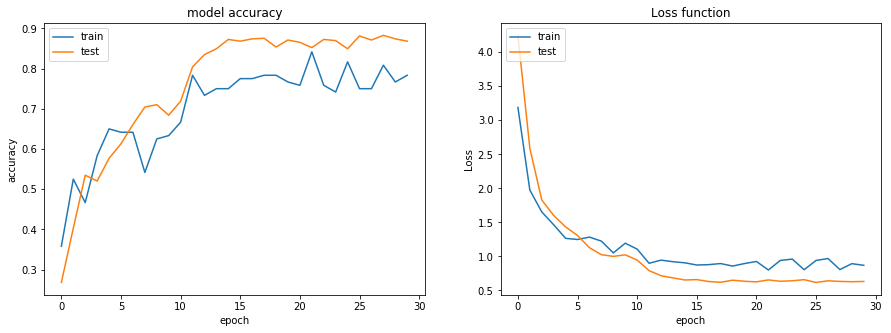

In [21]:
obj= PlotMetrics()
obj.draw(model_history)

### Conv3D Model: 

In [22]:
class convolution3D():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(15, image_x_shape, image_x_shape, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1),dim_ordering='th'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),dim_ordering='th'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),dim_ordering='th'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model

In [23]:
obj = convolution3D()
conv3d_model = obj.model(batch_size)
conv3d_optimiser = optimizers.Adam() #write your optimizer

conv3d_model.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 1), data_format="channels_first")`
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 1), data_format="channels_first")`
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 2), data_format="channels_first")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 84, 84, 8)     656       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 42, 42, 8)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 42, 42, 8)      32        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 42, 42, 16)     3472      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 21, 21, 16)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 21, 21, 16)     64        
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 21, 21, 32)     13856     
__________

In [24]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR(base_lr=0.1) # write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]
# roc_callback = RocCallback()
callbacks_list = [reduceLR,checkpoint]

In [25]:
conv3d_model_history = conv3d_model.fit_generator(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


23/23 [==============================] - 96s 4s/step - loss: 3.3093 - categorical_accuracy: 0.2188 - val_loss: 2.4835 - val_categorical_accuracy: 0.3833

Epoch 00001: saving model to model_init_2020-12-2517_25_36.748722/model_3d-00001-3.30930-0.21884-2.48348-0.38333.h5
Epoch 2/30
23/23 [==============================] - 87s 4s/step - loss: 2.5961 - categorical_accuracy: 0.2464 - val_loss: 2.3227 - val_categorical_accuracy: 0.3667

Epoch 00002: saving model to model_init_2020-12-2517_25_36.748722/model_3d-00002-2.59606-0.24638-2.32270-0.36667.h5
Epoch 3/30
23/23 [==============================] - 89s 4s/step - loss: 2.4826 - categorical_accuracy: 0.2870 - val_loss: 2.2333 - val_categorical_accuracy: 0.4083

Epoch 00003: saving model to model_init_2020-12-2517_25_36.748722/model_3d-00003-2.48264-0.28696-2.23327-0.40833.h5
Epoch 4/30
23/23 [==============================] - 90s 4s/step - loss: 2.3785 - categorical_accuracy: 0.3507 - val_loss: 2.0809 - val_categorical_accuracy: 0.5417

Epo


Epoch 00028: saving model to model_init_2020-12-2517_25_36.748722/model_3d-00028-1.38989-0.73623-1.49303-0.70000.h5
Epoch 29/30
23/23 [==============================] - 80s 3s/step - loss: 1.3534 - categorical_accuracy: 0.7420 - val_loss: 1.4768 - val_categorical_accuracy: 0.6833

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00029: saving model to model_init_2020-12-2517_25_36.748722/model_3d-00029-1.35335-0.74203-1.47678-0.68333.h5
Epoch 30/30
23/23 [==============================] - 78s 3s/step - loss: 1.3254 - categorical_accuracy: 0.7899 - val_loss: 1.3962 - val_categorical_accuracy: 0.7333

Epoch 00030: saving model to model_init_2020-12-2517_25_36.748722/model_3d-00030-1.32538-0.78986-1.39620-0.73333.h5


{'val_loss': [2.4834765195846558, 2.3227004408836365, 2.2332693934440613, 2.0809385180473328, 2.0604117810726166, 2.1300538182258606, 1.9631943106651306, 1.8243968486785889, 1.7877317368984222, 1.7788569629192352, 1.8327062726020813, 1.784808099269867, 1.695555955171585, 1.6529184579849243, 1.6283514201641083, 1.5946317315101624, 1.4690523743629456, 1.4865054488182068, 1.4851421117782593, 1.503682017326355, 1.5203335881233215, 1.4791677296161652, 1.4915139973163605, 1.492444932460785, 1.5217892825603485, 1.504506766796112, 1.5057207942008972, 1.4930329322814941, 1.4767840504646301, 1.3961952924728394], 'val_categorical_accuracy': [0.38333334028720856, 0.36666667461395264, 0.40833333879709244, 0.5416666865348816, 0.5416666641831398, 0.38333333656191826, 0.49166667461395264, 0.6083333343267441, 0.5833333432674408, 0.550000011920929, 0.6166666746139526, 0.6500000059604645, 0.6166666895151138, 0.6333333402872086, 0.6500000059604645, 0.6666666865348816, 0.7583333402872086, 0.683333322405815

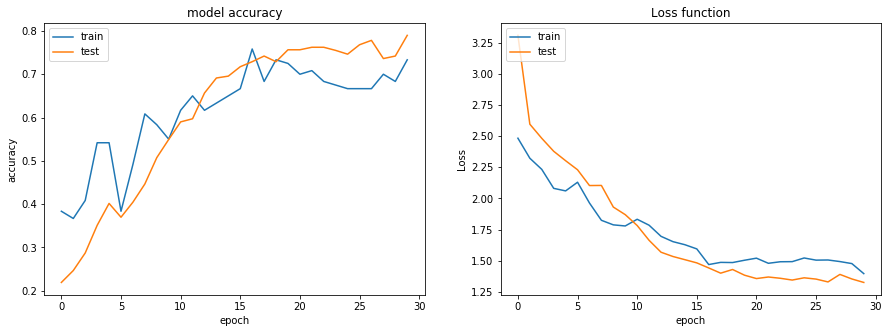

In [26]:
print(conv3d_model_history.history)
obj= PlotMetrics()
obj.draw(conv3d_model_history)